In [7]:
from __future__ import division, print_function

In [8]:
%load_ext autoreload
%autoreload 2
%pylab inline
# %load_ext wurlitzer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
import time
import numpy as np
from collections import namedtuple


from director import viewerclient as vc
from irispy import Polyhedron
import boxatlas.boxatlas as box
from boxatlas.contactstabilization import BoxAtlasContactStabilization

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
vis = vc.Visualizer()

In [65]:
surfaces = [
    box.Surface(Polyhedron.fromBounds([1.2, 0], [1.2, 2]),
            Polyhedron(np.array([[1, -1], [1, 1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-1.2, 0], [-1.2, 2]),
            Polyhedron(np.array([[-1, -1], [-1, 1]]), np.array([0, 0]))),
]

limb_idx_map = dict()
limb_idx_map["right_arm"] = 0
limb_idx_map["right_leg"] = 1
limb_idx_map["left_leg"] = 2
limb_idx_map["left_arm"] = 3

limb_velocity_limits = [4]*4

env = box.Environment(surfaces, Polyhedron.fromBounds([-1.2, 0], [1.2, 2]))
atlas = box.BoxAtlas()
atlas.limb_velocity_limits = limb_velocity_limits

large_leg_limb_bound = Polyhedron.fromBounds([-2.0, -1.0], [2.0, -0.5])
leg_names = ["left_leg", "right_leg"]
for limb in leg_names:
    idx = limb_idx_map[limb]
    atlas.limb_bounds[idx] = large_leg_limb_bound
    

params = BoxAtlasContactStabilization.get_optimization_parameters()
params['costs']['contact_force'] = 2e-2
params['costs']['arm_final_position'] = 1e2
params['costs']['leg_final_position'] = 1e2


def add_persistent_contact_constraints(opt, contact_name):
    """
    :param opt  BoxAtlasContactStabilization
    """
    idx = opt.robot.limb_idx_map[contact_name]
    contact = opt.vars.contact[idx]
    
    for var in contact.at_all_breaks():
        opt.prog.AddLinearConstraint(var[0] == 1)
        
def add_feet_always_in_contact_constraints(opt):
    contact_names = ["left_leg", "right_leg"]
    for contact_name in contact_names:
        add_persistent_contact_constraints(opt, contact_name)


def solveContactStabilization(opt=None, initial_state=None):
    if opt is None:
        if initial_state is None:
            initial_state = makeDefaultInitialState()            
        opt = BoxAtlasContactStabilization(initial_state, env, params=params)
        
    states, inputs, contact_indicator = opt.solve()
    ts = states.components[0].breaks
    
    solnData = namedtuple("SolutionData", ["opt" ,"states", "inputs", "contact_indicator", "ts"])
    solnData.opt = opt
    solnData.states = states
    solnData.inputs = inputs
    solnData.contact_indicator = contact_indicator
    solnData.ts = ts
    return solnData

        
def makeDefaultInitialState():
    initial_state = box.BoxAtlasState(atlas)
    initial_state.qcom = np.array([0, 1])
    initial_state.vcom = np.array([-0, 0.])
    initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])
    return initial_state


def makeDefaultOptimizationProblem(initial_state=None):
    if initial_state is None:
        initial_state = makeDefaultInitialState()
    opt = BoxAtlasContactStabilization(initial_state, env, params=params)
    return opt
    
def testInitialVCOM(vcom_x_list):
    solnDataList = []
    
    for vcom_x in vcom_x_list:
        initial_state = makeDefaultInitialState()
        initial_state.vcom = np.array([vcom_x, 0])
        solnDataList.append(solveContactStabilization(initial_state))
        
    return solnDataList

def getContactIndicatorVariable(solnData, contact_name="left_arm"):
    idx = limb_idx_map[contact_name]
    ts = solnData.ts
    return [solnData.contact_indicator[idx](t) for t in ts[:-1]]

def plotContactIndicator(solnData):
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = str(vcom_x)
    plt.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.show()
    

In [67]:
# solve a single problem and visualize the solution
initial_state = box.BoxAtlasState(atlas)
initial_state.qcom = np.array([0, 1])
initial_state.vcom = np.array([-2, 0.])
initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])

solnData = solveContactStabilization(initial_state=initial_state)
# visualizeContactStabilizationPlan(solnData)
box.planPlayback(vis, solnData, slider=True)
plotContactIndicator(solnData)

None

In [61]:
# Solve a sequence of problems for different initial velocities
vcom_x_list = np.arange(-1.0,-4, -0.25)
solnDataList = []
for vcom_x in vcom_x_list:
    initial_state = makeDefaultInitialState()
    initial_state.vcom = np.array([vcom_x, 0])
    
    opt = BoxAtlasContactStabilization(initial_state, env, params=params)
    add_feet_always_in_contact_constraints(opt)
    solnDataList.append(solveContactStabilization(opt=opt))

SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound


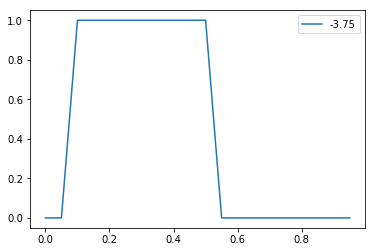

None

In [62]:
def plotContactIndicatorWidget(idx, solnDataList=solnDataList):
    plotContactIndicator(solnDataList[idx])
    
slider = widgets.IntSlider(min=0,max=len(solnDataList)-1,step=1,value=0)
interact(plotContactIndicatorWidget, idx=slider, solnDataList=fixed(solnDataList))

In [64]:
solnData = solnDataList[6]
vcom_x = solnData.states(0).vcom[0]
box.planPlayback(vis, solnData, slider=True)
print("com initial x velocity = ", vcom_x)

None

In [57]:
initial_state.vcom = np.array([-3.0, 0.])
opt = BoxAtlasContactStabilization(initial_state, env, params=params)
add_feet_always_in_contact_constraints(opt)
solnData = solveContactStabilization(opt=opt)
box.planPlayback(vis, solnData, slider=True)

None

In [39]:
solnData.contact_indicator[1](0.1)

array([ 1.])

In [ ]:
initial_state.qlimb[0]